In [1]:
import cv2
import json
from matplotlib import pyplot as plt
import numpy as np
import os
import random

# import a lot of things from keras:
# sequential model
from keras.models import Sequential

# layers
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, RandomFlip, RandomRotation, RandomContrast, RandomBrightness

# loss function
from keras.metrics import categorical_crossentropy

# callback functions
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# convert data to categorial vector representation
from keras.utils import to_categorical

# nice progress bar for loading data
from tqdm.notebook import tqdm

# helper function for train/test split
from sklearn.model_selection import train_test_split

# import confusion matrix helper function
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# import pre-trained model
from keras.applications.vgg16 import VGG16

# include only those gestures
CONDITIONS = ['like', 'stop']

# image size
IMG_SIZE = 64
SIZE = (IMG_SIZE, IMG_SIZE)

# number of color channels we want to use
# set to 1 to convert to grayscale
# set to 3 to use color images
COLOR_CHANNELS = 3

## helper function to load and parse annotations

In [3]:
annotations = dict()

for condition in CONDITIONS:
    with open(f'../gesture_dataset_sample/_annotations/{condition}.json') as f:
        annotations[condition] = json.load(f)

## helper function to pre-process images (color channel conversion and resizing)

In [6]:
def preprocess_image(img):
    if COLOR_CHANNELS == 1:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_resized = cv2.resize(img, SIZE)
    return img_resized

## load images and annotations

In [9]:
images = [] # stores actual image data
labels = [] # stores labels (as integer - because this is what our network needs)
label_names = [] # maps label ints to their actual categories so we can understand predictions later

# loop over all conditions
# loop over all files in the condition's directory
# read the image and corresponding annotation
# crop image to the region of interest
# preprocess image
# store preprocessed image and label in corresponding lists
for condition in CONDITIONS:
    for filename in tqdm(os.listdir(f'../gesture_dataset_sample/{condition}')):
        # extract unique ID from file name
        UID = filename.split('.')[0]
        img = cv2.imread(f'../gesture_dataset_sample/{condition}/{filename}')
        
        # get annotation from the dict we loaded earlier
        try:
            annotation = annotations[condition][UID]
        except Exception as e:
            print(e)
            continue
        
        # iterate over all hands annotated in the image
        for i, bbox in enumerate(annotation['bboxes']):
            # annotated bounding boxes are in the range from 0 to 1
            # therefore we have to scale them to the image size
            x1 = int(bbox[0] * img.shape[1])
            y1 = int(bbox[1] * img.shape[0])
            w = int(bbox[2] * img.shape[1])
            h = int(bbox[3] * img.shape[0])
            x2 = x1 + w
            y2 = y1 + h
            
            # crop image to the bounding box and apply pre-processing
            crop = img[y1:y2, x1:x2]
            preprocessed = preprocess_image(crop)
            
            # get the annotated hand's label
            # if we have not seen this label yet, add it to the list of labels
            label = annotation['labels'][i]
            if label not in label_names:
                label_names.append(label)
            
            label_index = label_names.index(label)
            
            images.append(preprocessed)
            labels.append(label_index)

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

## let's have a look at one of the images

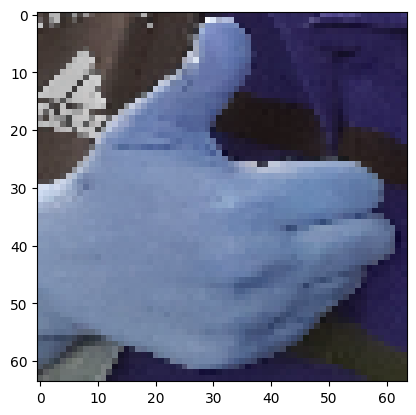

In [14]:
plt.imshow(random.sample(images, 1)[0])

## split data set into train and test

x is for the actual data, y is for the label (this is convention)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

512
128
512
128


## transform data sets into a format compatible with our neural network

image data has to be a numpy array with following dimensions: [image_id, y_axis, x_axis, color_channels]

furthermore, scale all values to a range of 0 to 1

training data has to be converted to a categorial vector ("one hot"):

[3] --> [0, 0, 0, 1, 0, ..., 0]

In [16]:
X_train = np.array(X_train).astype('float32')
X_train = X_train / 255.

X_test = np.array(X_test).astype('float32')
X_test = X_test / 255.

y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

train_label = y_train_one_hot
test_label = y_test_one_hot

X_train = X_train.reshape(-1, IMG_SIZE, IMG_SIZE, COLOR_CHANNELS)
X_test = X_test.reshape(-1, IMG_SIZE, IMG_SIZE, COLOR_CHANNELS)

print(X_train.shape, X_test.shape, train_label.shape, test_label.shape)

(512, 64, 64, 3) (128, 64, 64, 3) (512, 3) (128, 3)


# Hyperparameters to be configured here

## Hyperparameter for this assignment: 
## Kernel size for the convolution layer

### Values

For the Values to test i chose the following values for the following reasons:
1. 9x9: The standart value for the kernel size
2. 5x5: A slightly bigger kernel size, also a common value
3. 1x1: No kernel size at all, to see how the model performs without a kernel size
4. 25x25: A big kernel size, to see the effect of a bigger, but not too large kernel
5. 63x63: A very big kernel size, to see what happens when the kernel is too large

### Predicted Outcome

1. 9x9: The model should perform well with this kernel size
2. 5x5: The model should also perform pretty good. It might be a bit worse and the training time will be increased
3. 1x1: The model should perform very bad, as the kernel size is too small to recognize any patterns at all and the training time will be very high
4. 25x25: The model should perform a bit worse, but it might still be able to recognize patterns
5. 63x63: The model should perform very bad, as the kernel size is too big to recognize any patterns at all

### Results

1. 9x9: The model performed very well with this kernel size
    iterations: 11
2. 5x5: The model performed very well with this kernel size
    - iterations: 12 
    - accuracy: 0.9958 
    - loss: 0.0305 
    - val_accuracy: 0.9531 
    - val_loss: 0.2410
    - Total params: 313,739
3. 1x1: The model performed surprisingly well. 80% accuracy is still an acceptable value. I thought the training time would be a lot longer.
    - iterations: 38
    - accuracy: 0.8067 
    - loss: 0.4611 
    - val_accuracy: 0.8359 
    - val_loss: 0.5696
    - ~15 ms/step
    - Total params: 78,731
    - Training took 39s
4. 25x25:
    - iterations: 9
    - accuracy: 0.4128 
    - loss: 1.0431 
    - val_accuracy: 0.3672 
    - val_loss: 1.0602
    - ~340 ms/step 
    - Total params: 6,188,939
    - Training took 3m 23s
5. 63x63: The model performed terrible
    - iterations: 6
    - accuracy: 0.3327 - This is 33% due to the model predicting everything as "stop"
    - loss: 6.8618 
    - val_accuracy: 0.3516 
    - val_loss: 1.5955
    - 1 sec/step
    - Total params: 38,933,387
    - Training took 7m35s

In [88]:
# variables for hyperparameters
batch_size = 8
epochs = 50
num_classes = len(label_names)
activation = 'relu'
activation_conv = 'leaky_relu'  # LeakyReLU
layer_count = 2
num_neurons = 64
kernel_size = (25, 25)
KERNEL_SAVENAME = "25x25"

# define model structure
# with keras, we can use a model's add() function to add layers to the network one by one
model = Sequential()

# data augmentation (this can also be done beforehand - but don't augment the test dataset!)
model.add(RandomFlip('horizontal'))
model.add(RandomContrast(0.1))
#model.add(RandomBrightness(0.1))
#model.add(RandomRotation(0.2))

# first, we add some convolution layers followed by max pooling
model.add(Conv2D(64, kernel_size=kernel_size, activation=activation_conv, input_shape=(SIZE[0], SIZE[1], COLOR_CHANNELS), padding='same'))
model.add(MaxPooling2D(pool_size=(4, 4), padding='same'))

model.add(Conv2D(32, kernel_size, activation=activation_conv, padding='same'))
model.add(MaxPooling2D(pool_size=(3, 3), padding='same'))

model.add(Conv2D(32, kernel_size, activation=activation_conv, padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

# dropout layers can drop part of the data during each epoch - this prevents overfitting
model.add(Dropout(0.2))

# after the convolution layers, we have to flatten the data so it can be fed into fully connected layers
model.add(Flatten())

# add some fully connected layers ("Dense")
for i in range(layer_count - 1):
    model.add(Dense(num_neurons, activation=activation))

model.add(Dense(num_neurons, activation=activation))

# for classification, the last layer has to use the softmax activation function, which gives us probabilities for each category
model.add(Dense(num_classes, activation='softmax'))

# specify loss function, optimizer and evaluation metrics
# for classification, categorial crossentropy is used as a loss function
# use the adam optimizer unless you have a good reason not to
model.compile(loss=categorical_crossentropy, optimizer="adam", metrics=['accuracy'])

# define callback functions that react to the model's behavior during training
# in this example, we reduce the learning rate once we get stuck and early stopping
# to cancel the training if there are no improvements for a certain amount of epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)
stop_early = EarlyStopping(monitor='val_loss', patience=3)

C:\Users\brede\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## now, we can train the model using the fit() function
## this will take a while

In [89]:
history = model.fit(
    X_train,
    train_label,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(X_test, test_label),
    callbacks=[reduce_lr, stop_early]
)

Epoch 1/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 29s 384ms/step - accuracy: 0.4273 - loss: 1.3804 - val_accuracy: 0.3516 - val_loss: 1.1427 - learning_rate: 0.0010
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 23s 354ms/step - accuracy: 0.3294 - loss: 1.5060 - val_accuracy: 0.3516 - val_loss: 6.5103 - learning_rate: 0.0010
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 22s 340ms/step - accuracy: 0.3790 - loss: 3.1627 - val_accuracy: 0.4219 - val_loss: 1.3222 - learning_rate: 0.0010
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 22s 343ms/step - accuracy: 0.3358 - loss: 1.4965 - val_accuracy: 0.3516 - val_loss: 1.1212 - learning_rate: 2.0000e-04
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 22s 342ms/step - accuracy: 0.3600 - loss: 1.1838 - val_accuracy: 0.3828 - val_loss: 1.0602 - learning_rate: 2.0000e-04
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 22s 337ms/step - accuracy: 0.4170 - loss: 1.0967 - val_accuracy: 0.3672 - val_loss: 1.0539 - learning_rate: 2.0000e-04
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 22s 339ms/step - accuracy: 0.400

In [90]:
# let's have a look at our model
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_5 (RandomFlip)      │ (8, 64, 64, 3)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast_5               │ (8, 64, 64, 3)         │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (8, 64, 64, 64)        │       120,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (8, 16, 16, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (8, 16, 16, 32)        │     1,280,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (8, 6, 6, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (8, 6, 6, 32)          │       640,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (8, 3, 3, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (8, 3, 3, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (8, 288)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (8, 64)                │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (8, 64)                │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (8, 3)                 │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,188,939 (23.61 MB)

 Trainable params: 2,062,979 (7.87 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,125,960 (15.74 MB)

## Plot accuracy and loss of the training process

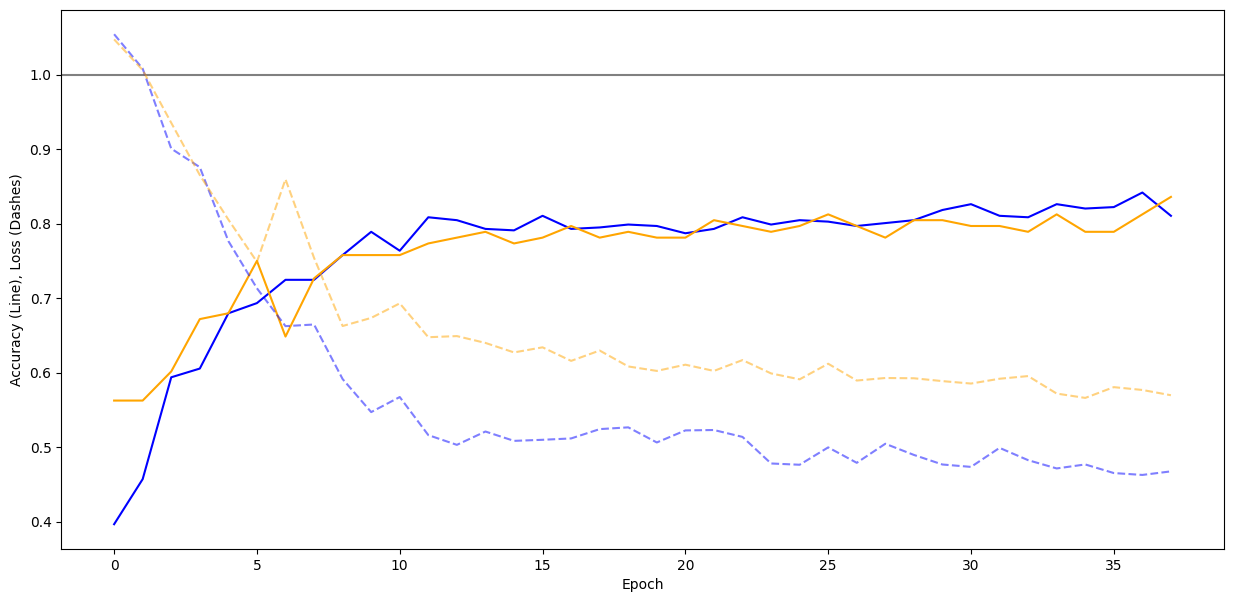

In [68]:
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

fig = plt.figure(figsize=(15, 7))
ax = plt.gca()

ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy (Line), Loss (Dashes)')

ax.axhline(1, color='gray')

plt.plot(accuracy, color='blue')
plt.plot(val_accuracy, color='orange')
plt.plot(loss, '--', color='blue', alpha=0.5)
plt.plot(val_loss, '--', color='orange', alpha=0.5)

## saving the model

the function will create a directory for your model and save structure and weights in there

sometimes you will see the .h5 format being used - even though this is a bit faster and needs less space, it comes with its limitations and isn't used that much any more

In [69]:
model.save(f'gesture_recognition_{KERNEL_SAVENAME}.keras')

# and this is how you load the model
# model = keras.models.load_model("gesture_recognition")

## visualize classification results with a confusion matrix

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
before [[3.80657047e-01 3.67263965e-02 5.82616568e-01]
 [2.83230722e-01 6.14278972e-01 1.02490261e-01]
 [6.14901841e-01 1.00589786e-02 3.75039101e-01]
 [4.65412945e-01 6.56011095e-03 5.28026938e-01]
 [9.50666368e-01 1.75692979e-02 3.17643136e-02]
 [8.75563562e-01 1.08487844e-01 1.59486085e-02]
 [9.74939644e-01 7.01079750e-03 1.80495046e-02]
 [8.97673190e-01 9.36286375e-02 8.69815703e-03]
 [7.74549484e-01 1.93063747e-02 2.06144169e-01]
 [8.15851092e-01 1.36340633e-02 1.70514837e-01]
 [4.28689681e-02 2.54121363e-01 7.03009605e-01]
 [6.76164478e-02 8.18771720e-01 1.13611788e-01]
 [1.42025009e-01 6.66904032e-01 1.91070944e-01]
 [5.09396046e-02 9.31630470e-03 9.39744115e-01]
 [9.95222390e-01 1.30382285e-03 3.47382762e-03]
 [2.48555280e-02 1.30143110e-02 9.62130189e-01]
 [1.65345579e-01 7.64380634e-01 7.02738464e-02]
 [2.25551408e-02 5.60099259e-03 9.71843839e-01]
 [8.42104182e-02 8.14241707e-01 1.01547867e-01]
 [5.09540848e-02 5.25253154e-02 8.96520495e

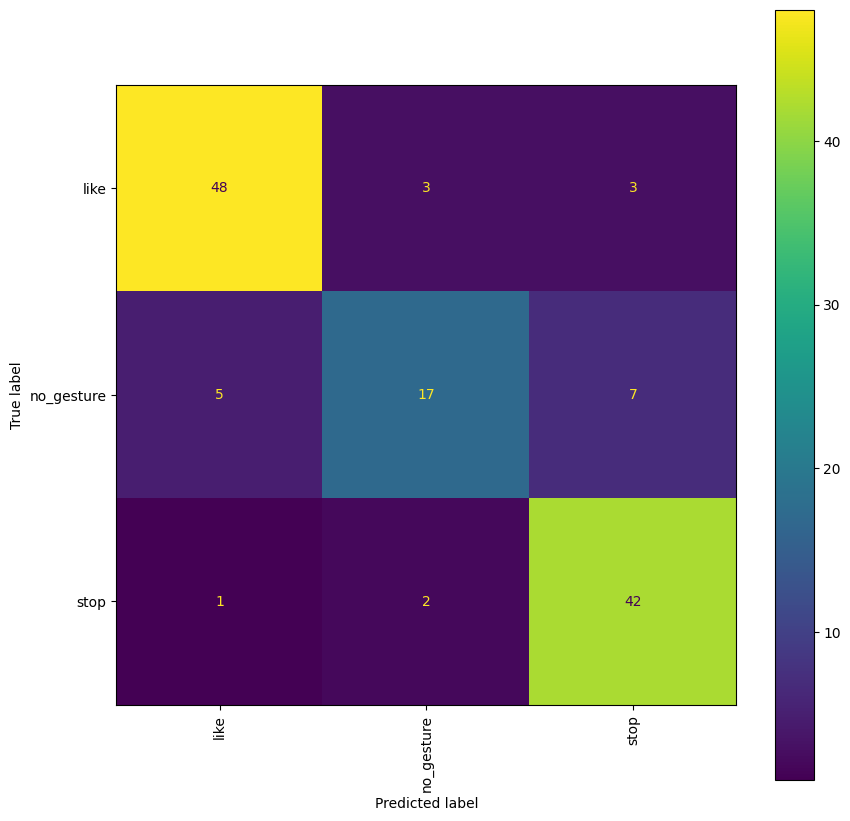

In [70]:
# let the model make predictions for our training data
y_predictions = model.predict(X_test)

# we get a 2D numpy array with probabilities for each category
print('before', y_predictions)

# to build a confusion matrix, we have to convert it to classifications
# this can be done by using the argmax() function to set the probability to 1 and the rest to 0
y_predictions = np.argmax(y_predictions, axis=1)

print('probabilities', y_predictions)

# create and plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_predictions)

fig = plt.figure(figsize=(10, 10))

ConfusionMatrixDisplay(conf_matrix, display_labels=label_names).plot(ax=plt.gca())

plt.xticks(rotation=90, ha='center')
pass

## let's test our model in action

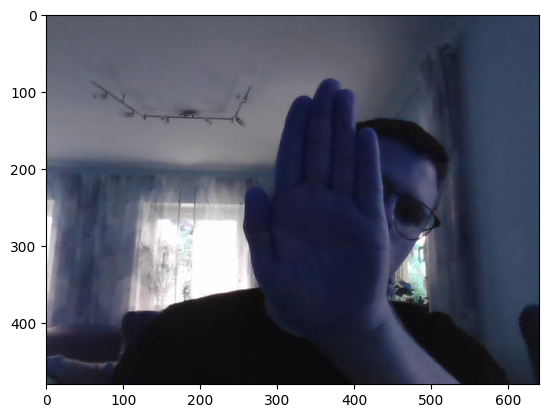

In [25]:
cap = cv2.VideoCapture(0)
ret, frame = cap.read()
if COLOR_CHANNELS == 1:
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
cap.release()
plt.imshow(frame)

## manual cropping for demonstration purposes - you can do better!

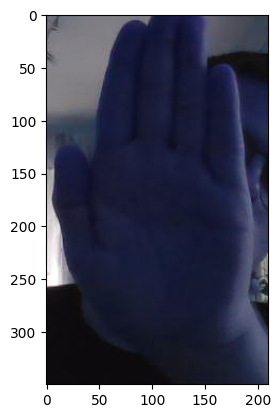

In [62]:
crop = frame[100:450, 250:460]
plt.imshow(crop)

(64, 64, 3)

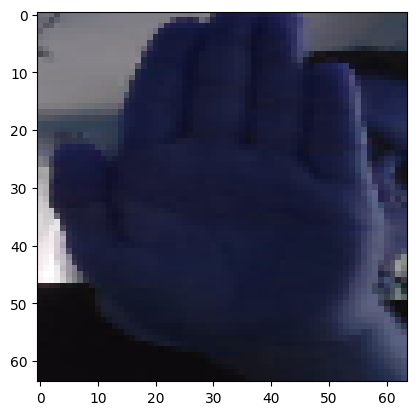

In [63]:
resized = cv2.resize(crop, SIZE)#[20:350, 200:420], SIZE)
plt.imshow(resized)
resized.shape

In [87]:
reshaped = resized.reshape(-1, IMG_SIZE, IMG_SIZE, COLOR_CHANNELS)
reshaped.shape
prediction = model.predict(reshaped)

print(label_names[np.argmax(prediction)], np.max(prediction))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
stop 1.0
